In [645]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve

warnings.filterwarnings('ignore')

In [314]:
plt.style.use('fivethirtyeight')
np.random.seed(seed=42)

## Get Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174551 entries, A to ZUMZ
Data columns (total 61 columns):
returns                  174551 non-null float64
t-1                      174551 non-null float64
t-2                      174551 non-null float64
t-3                      174551 non-null float64
t-4                      174551 non-null float64
t-5                      174551 non-null float64
t-6                      174551 non-null float64
t-7                      174551 non-null float64
t-8                      174551 non-null float64
t-9                      174551 non-null float64
t-10                     174551 non-null float64
t-11                     174551 non-null float64
t-12                     174551 non-null float64
year_2010                174551 non-null uint8
year_2011                174551 non-null uint8
year_2012                174551 non-null uint8
year_2013                174551 non-null uint8
year_2014                174551 non-null uint8
year_2015               

### Stock Prices

In [7]:
y = data.returns
X = data.drop('returns', axis=1)

## Explore Data

In [8]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    174551.000000
mean          0.009913
std           0.055606
min          -0.128560
10%          -0.064080
20%          -0.036451
30.0%        -0.017798
40%          -0.002855
50%           0.010522
60%           0.023904
70%           0.038457
80%           0.056050
90%           0.082772
max           0.146335
Name: returns, dtype: float64

In [9]:
y_binary = (y>0).astype(int)

## Bagging

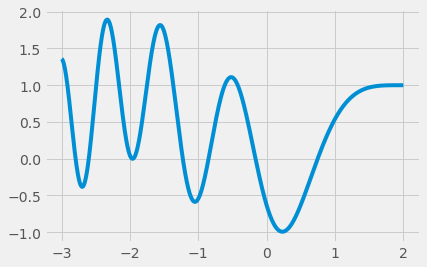

In [608]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot();

In [646]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise_to_signal

X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

In [647]:
# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

In [648]:
result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)

In [649]:
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'-0.82%'

In [650]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'-0.76%'

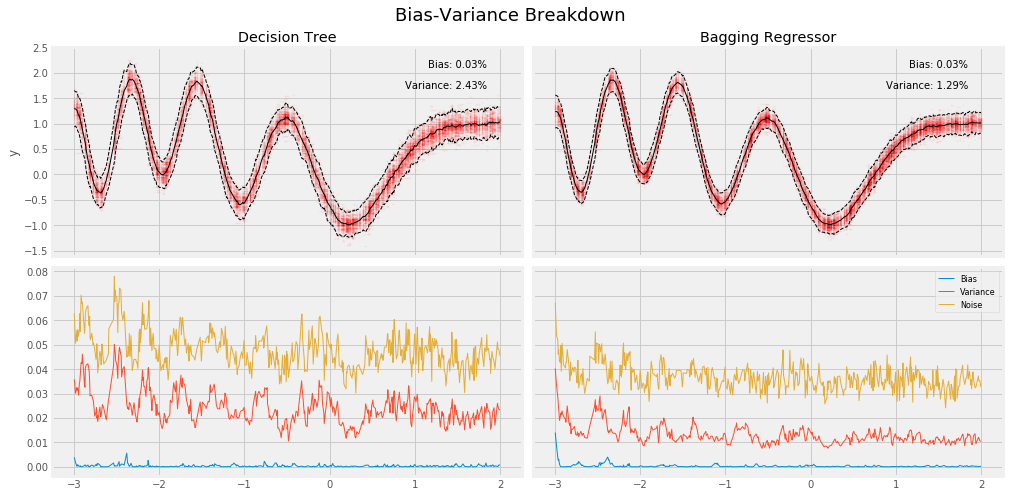

In [651]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    
    (r.drop('error', axis=1).sort_index()
     .rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True))

axes[-1].legend(fontsize=8)
fig.suptitle('Bias-Variance Breakdown', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Random Forests

In [652]:
rf_clf = RandomForestClassifier(n_estimators=10, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None)

In [679]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {'n_estimators': [200, 400],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [50, 100],
              'max_features': ['auto']
              }

In [680]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=3,
                          refit=True,
                          return_train_score=True,
                             verbose=1)

In [681]:
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 400], 'max_depth': [10, 15, 20], 'min_samples_leaf': [50, 100], 'max_features': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [682]:
gridsearch_clf.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'n_estimators': 400}

In [683]:
gridsearch_clf.best_score_

0.725331349764986

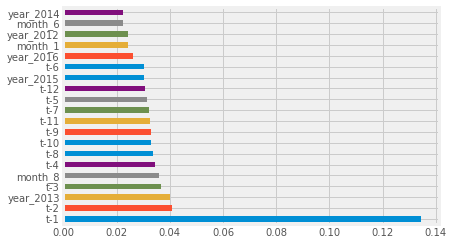

In [686]:
pd.Series(gridsearch_clf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).iloc[:20].plot.barh();